In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set pandas display options
# Display all columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', 100) 
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load the dataset
df = pd.read_csv("loan.csv", low_memory=False)
# print no of rows and columns
df.shape



(39717, 111)

Data Dimensions: (39717, 111)
Data Types:
id                              int64
member_id                       int64
loan_amnt                       int64
funded_amnt                     int64
funded_amnt_inv               float64
                               ...   
tax_liens                     float64
tot_hi_cred_lim               float64
total_bal_ex_mort             float64
total_bc_limit                float64
total_il_high_credit_limit    float64
Length: 111, dtype: object

Columns with Missing Values:
emp_title                          2459
emp_length                         1075
desc                              12942
title                                11
mths_since_last_delinq            25682
mths_since_last_record            36931
revol_util                           50
last_pymnt_d                         71
next_pymnt_d                      38577
last_credit_pull_d                    2
collections_12_mths_ex_med           56
mths_since_last_major_derog       39717
ann

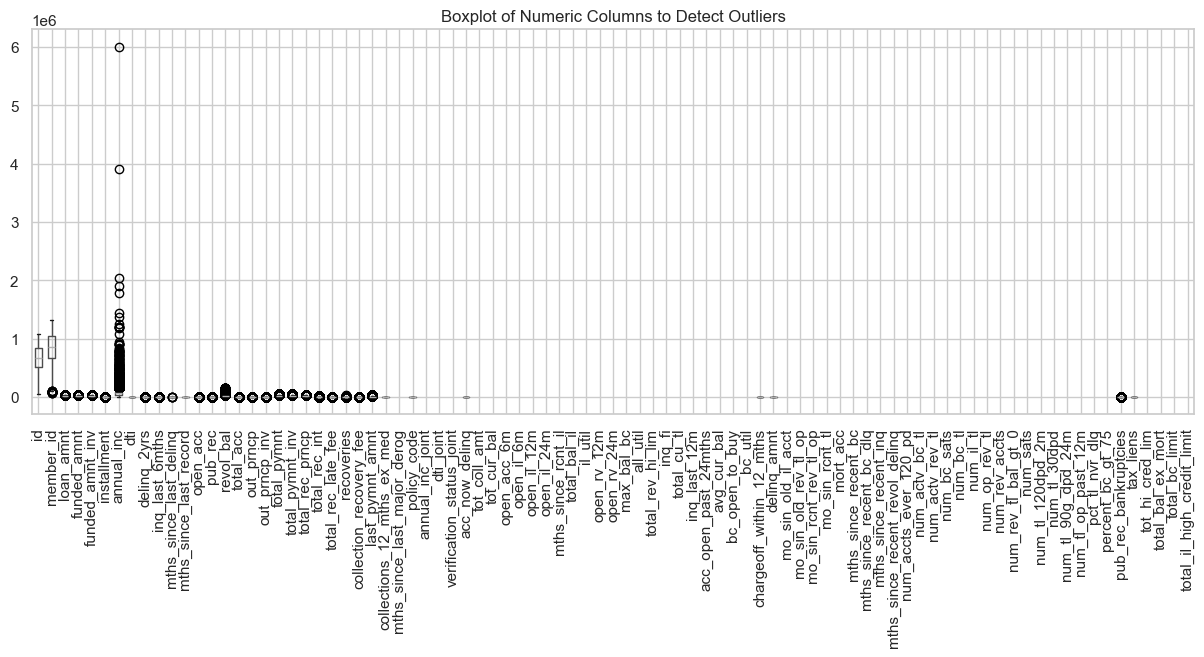


Number of Duplicate Rows: 0


In [91]:
# Initial Inspection and cleaning

# 1. Check Data Types and Dimensions
print("Data Dimensions:", df.shape)  # Print the number of rows and columns
print("Data Types:")
# Display data types of each column
print(df.dtypes) 

# 2. Check for Null Values
null_counts = df.isnull().sum()
print("\nColumns with Missing Values:")
# Display columns with missing values
print(null_counts[null_counts > 0])  

# 3. Summary Statistics
print("\nSummary Statistics:")
# Show statistics for all columns, including non-numeric
print(df.describe(include='all')) 


# Interpretation of Variables

# Some of the Variables with its descriptions from data dictionary

variable_descriptions = {
    "loan_amnt": "The total loan amount requested by the borrower.",
    "term": "The duration of loan repayment, e.g., 36 or 60 months.",
    "int_rate": "Interest rate on the loan.",
    "installment": "Monthly payment due from the borrower.",
    "grade": "Loan grade assigned by the lending institution.",
    "acc_now_delinq":"The number of accounts on which the borrower is now delinquent.",
    "delinq_amnt": "The past-due amount owed for the accounts on which the borrower is now delinquent.",
    "dti": "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.",
    "verification_status": "Indicates if income was verified by LC, not verified, or if the income source was verified",
    
}

# Display variable descriptions
print("\nVariable Descriptions:")
for var, desc in variable_descriptions.items():
    print(f"{var}: {desc}")


# 1. Missing Values
print("\nData Quality Issues:")
print("1. Missing Values:")
# Display missing values for columns with issues
print(null_counts[null_counts > 0])  

# 2. Outliers
# Identify potential outliers in numeric columns using boxplots
numeric_columns = df.select_dtypes(include=[np.number]).columns  # Select only numeric columns

plt.figure(figsize=(15, 5))
df[numeric_columns].boxplot(rot=90)  # Rotate labels for readability
plt.title("Boxplot of Numeric Columns to Detect Outliers")
plt.show()


# 3. Duplicate Entries
duplicates = df[df.duplicated()]
print("\nNumber of Duplicate Rows:", duplicates.shape[0])





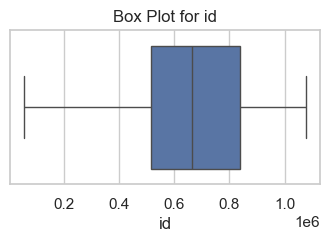

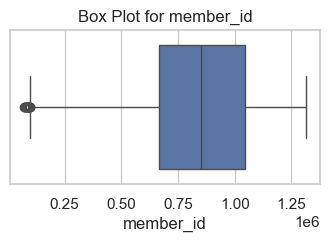

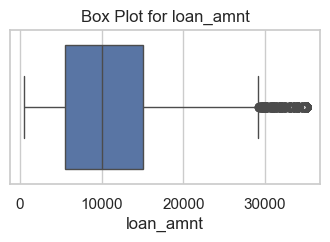

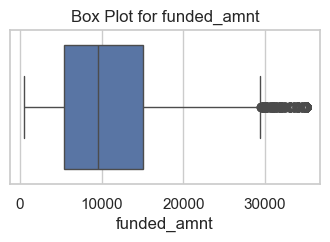

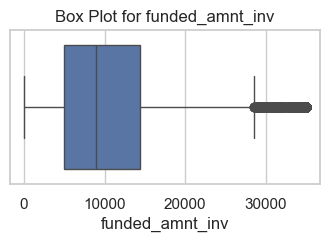

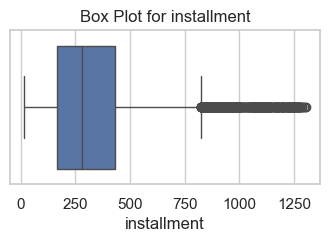

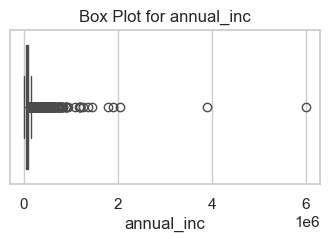

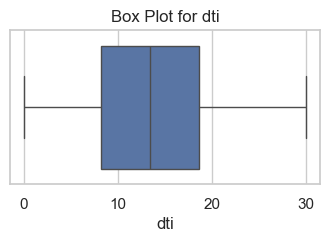

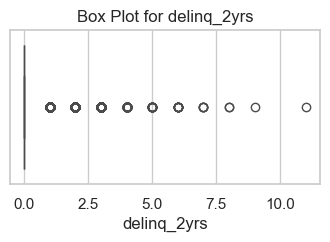

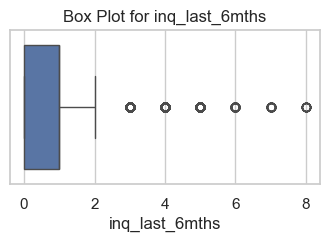

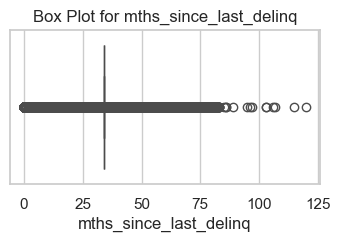

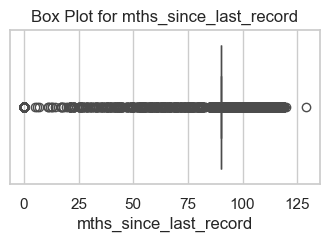

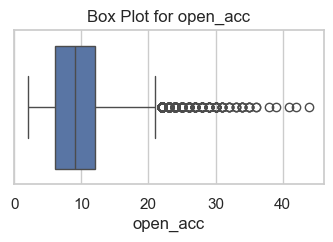

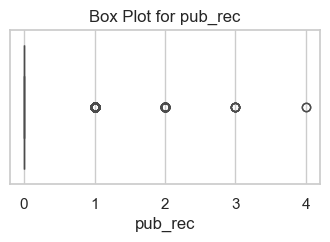

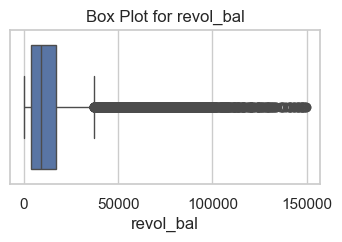

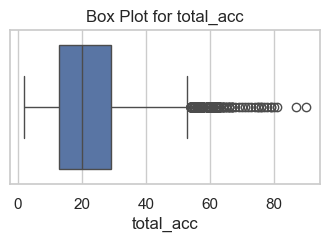

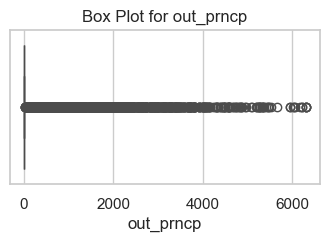

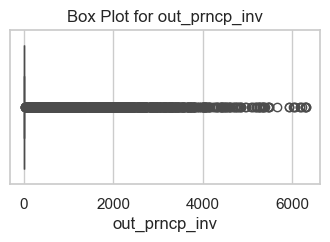

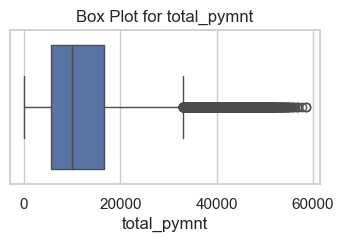

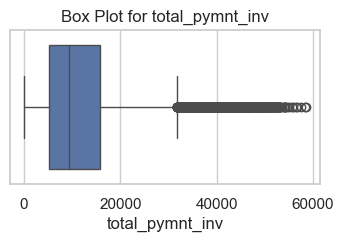

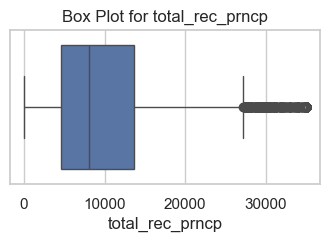

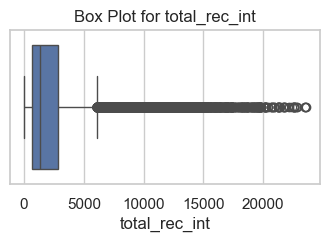

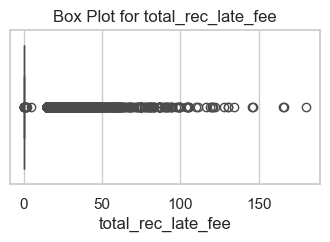

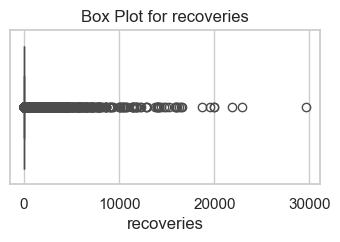

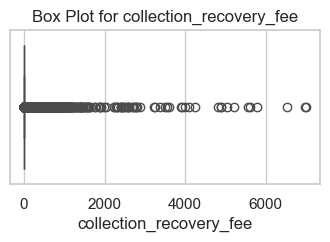

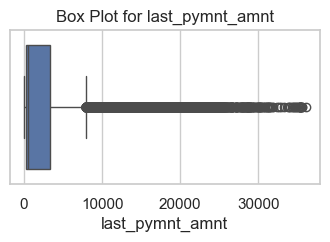

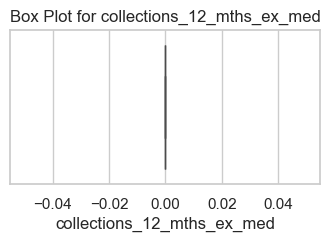

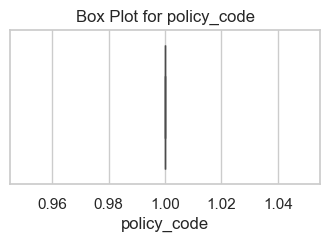

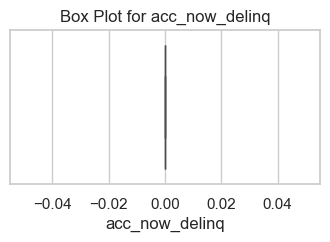

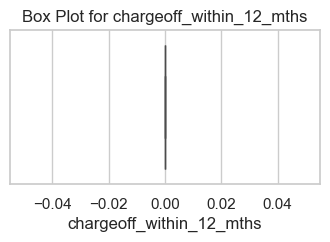

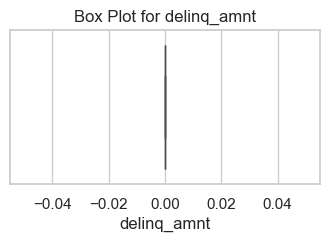

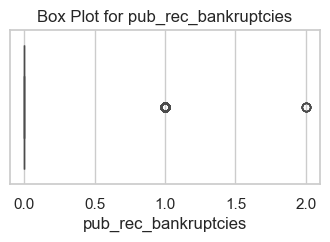

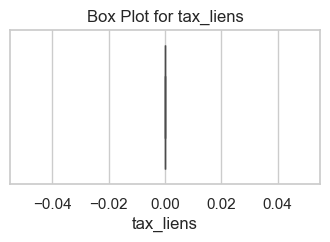

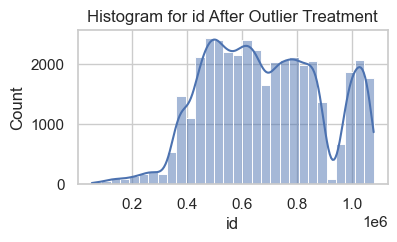

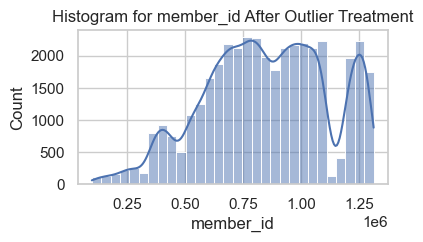

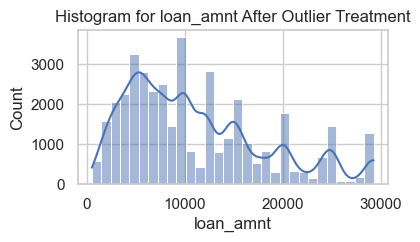

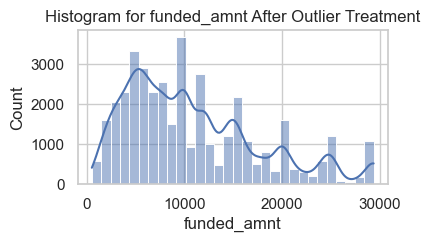

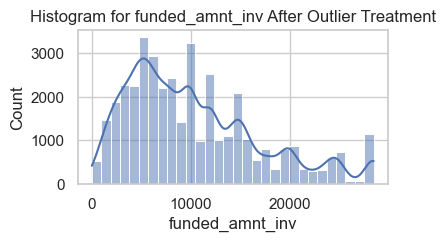

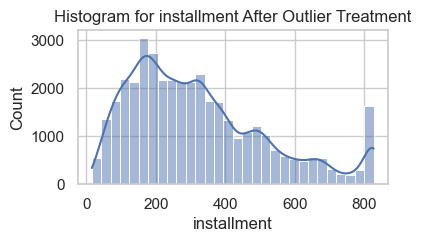

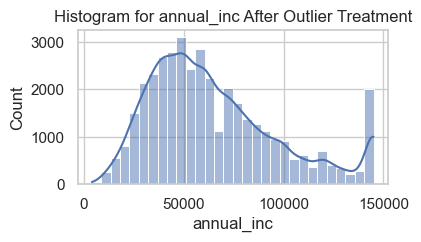

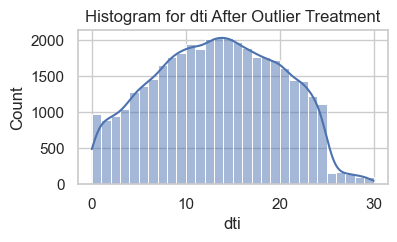

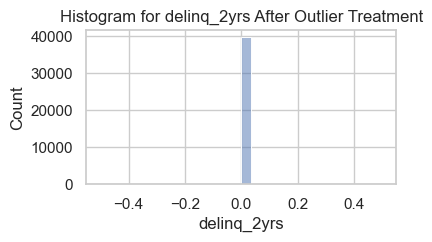

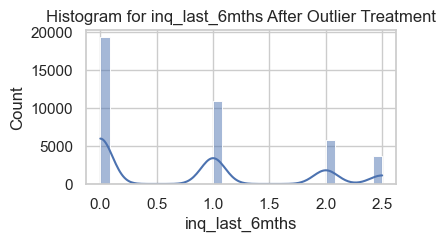

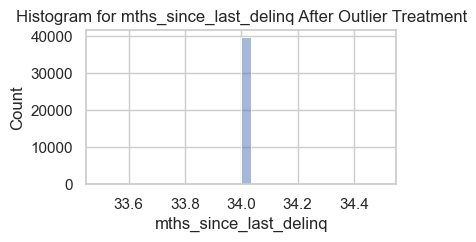

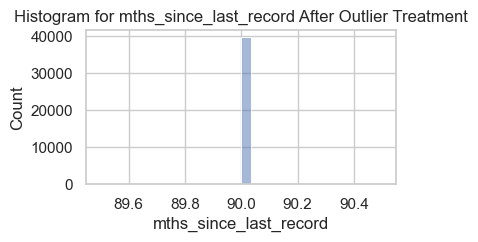

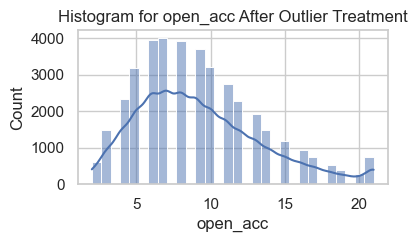

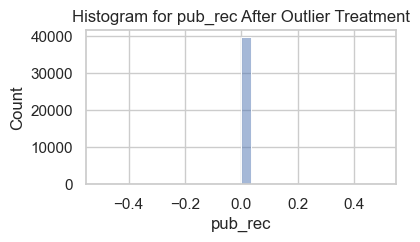

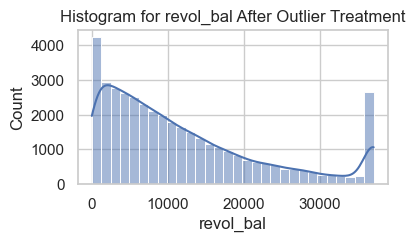

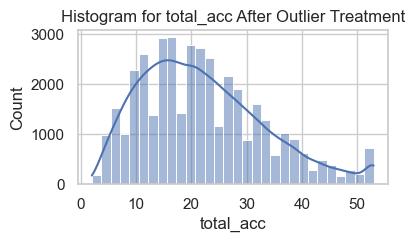

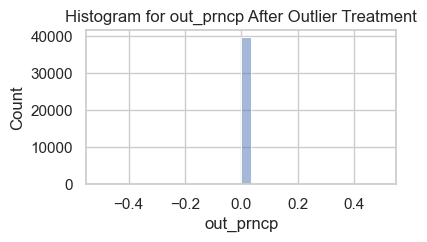

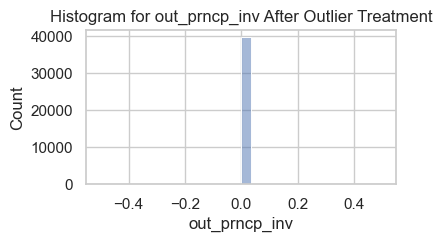

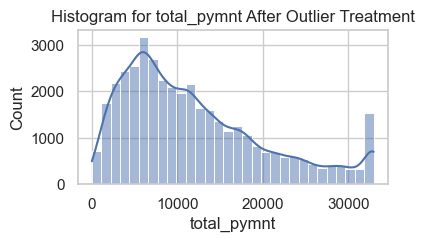

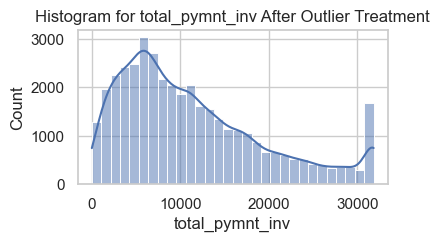

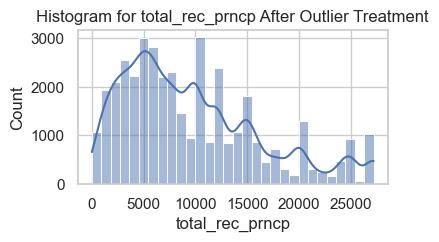

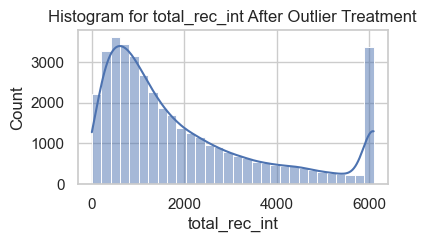

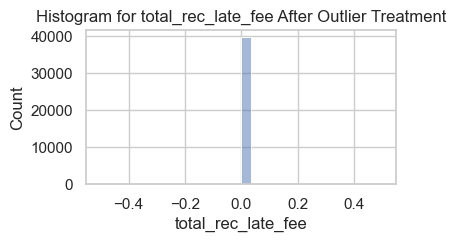

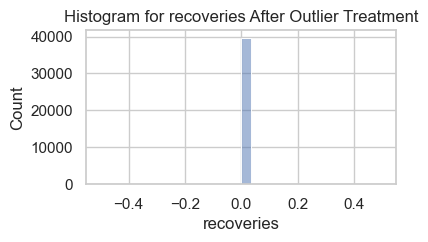

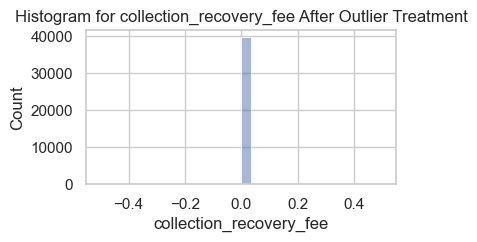

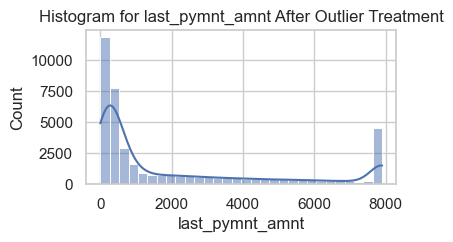

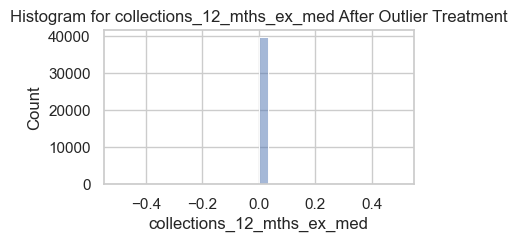

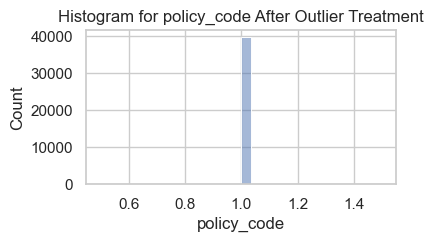

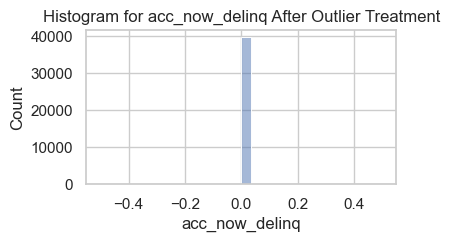

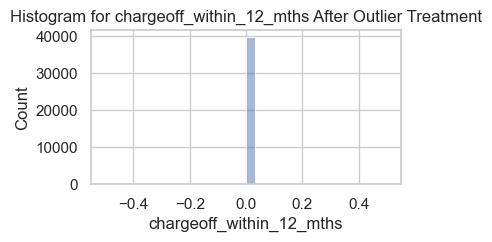

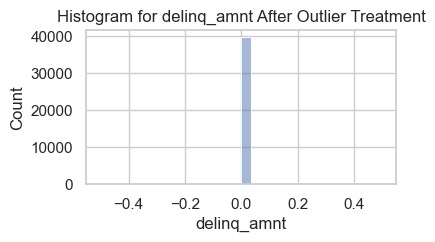

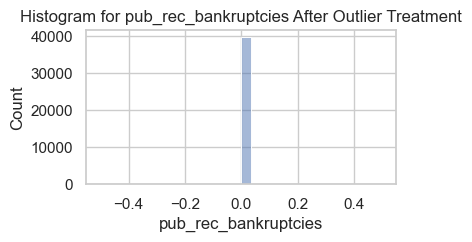

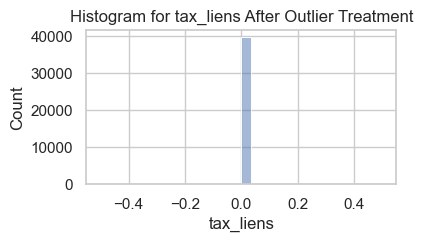

In [93]:
# Handling missing values
# Numeric variables: Impute with median  because it is robust to outliers.
numeric_columns = df.select_dtypes(include=np.number).columns
for col in numeric_columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].median())




# Categorical variables: Impute with mode as it is the most frequent value.
categorical_columns = df.select_dtypes(include='object').columns
for col in categorical_columns:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])



# Drop columns with excessive missing values (>80% missing)
threshold = 0.8 * len(df)
columns_to_drop = [col for col in df.columns if df[col].isnull().sum() > threshold]
df = df.drop(columns=columns_to_drop, axis=1)



# Specific domain-based imputations
# For 'emp_title', 'emp_length': fill with 'Unknown' and '0 years'
df['emp_title'] = df['emp_title'].fillna('Unknown')
df['emp_length'] = df['emp_length'].fillna('0 years')

# For 'desc': drop if irrelevant, else impute with 'No description'
df['desc'] = df['desc'].fillna('No description')

# For 'title': use mode as it's descriptive and could hold business value
df['title'] = df['title'].fillna(df['title'].mode()[0])

# For dates like 'last_pymnt_d', 'next_pymnt_d', etc., impute with the earliest available date
date_columns = ['last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d']
for col in date_columns:
    df[col] = df[col].fillna(df[col].min())

# For financial indicators with high missing values but domain relevance, impute with 0
financial_columns = ['tot_coll_amt', 'tot_cur_bal', 'revol_util', 'collections_12_mths_ex_med']
for col in financial_columns:
    if col in df.columns:
        df[col] = df[col].fillna(0)

# For columns with specific business importance, impute accordingly
df['pub_rec_bankruptcies'] = df['pub_rec_bankruptcies'].fillna(0)
df['tax_liens'] = df['tax_liens'].fillna(0)

# Define numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns



# Step 1: Visualize Outliers Using Box Plots
for col in numeric_columns:
    plt.figure(figsize=(4, 2))
    sns.boxplot(x=df[col])
    plt.title(f"Box Plot for {col}")
    plt.show()

# Step 2: Identify Outliers Using the IQR Method
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)  # First Quartile
    Q3 = series.quantile(0.75)  # Third Quartile
    IQR = Q3 - Q1  # Interquartile Range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Step 3: Cap Outliers
for col in numeric_columns:
    lower_bound, upper_bound = detect_outliers_iqr(df[col])
    # Cap values at the boundaries
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])




# Step 4: Visualize Transformed Data
for col in numeric_columns:
    plt.figure(figsize=(4, 2))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Histogram for {col} After Outlier Treatment")
    plt.show()






In [58]:
# After impution dataset looks like 
print("After impution dataset shape would be:", df.shape)
print("After impution dataset looks like.\n\n\n", df.head())


After impution dataset shape would be: (39717, 57)
After impution dataset looks like.


           id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0 1077501.00 1296599.00    5000.00      5000.00          4975.00   36 months   
1 1077430.00 1314167.00    2500.00      2500.00          2500.00   60 months   
2 1077175.00 1313524.00    2400.00      2400.00          2400.00   36 months   
3 1076863.00 1277178.00   10000.00     10000.00         10000.00   36 months   
4 1075358.00 1311748.00    3000.00      3000.00          3000.00   60 months   

  int_rate  installment grade sub_grade                 emp_title emp_length  \
0   10.65%       162.87     B        B2                   US Army  10+ years   
1   15.27%        59.83     C        C4                     Ryder   < 1 year   
2   15.96%        84.33     C        C5                   US Army  10+ years   
3   13.49%       339.31     C        C1       AIR RESOURCES BOARD  10+ years   
4   12.69%        67.79     B 

Function to plot bar charts for categorical variables



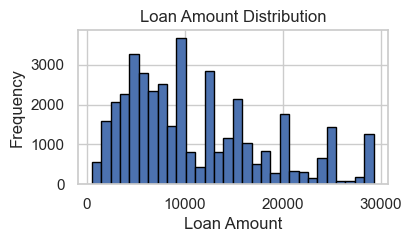

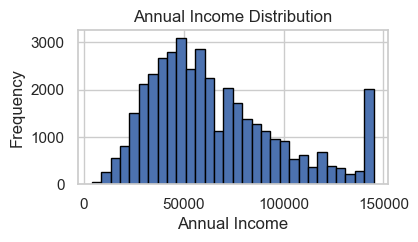

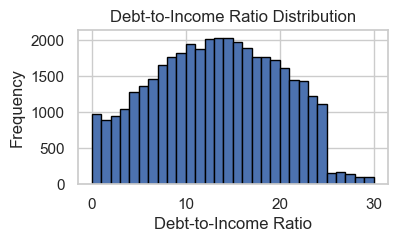

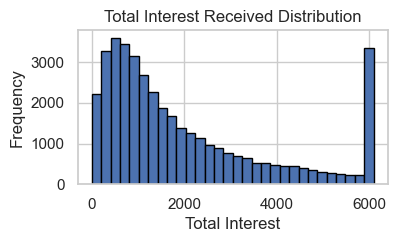

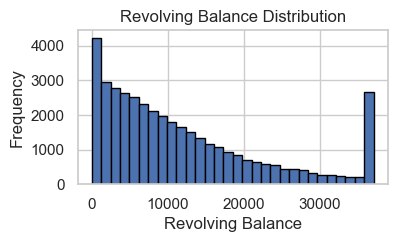

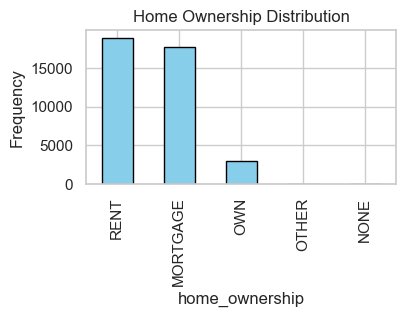

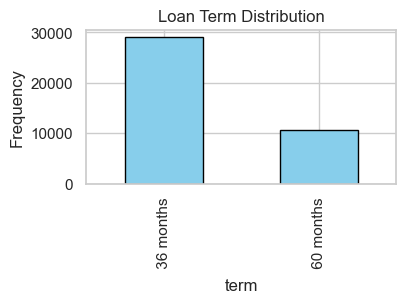

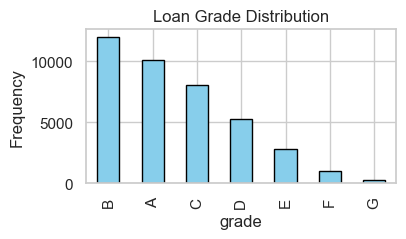

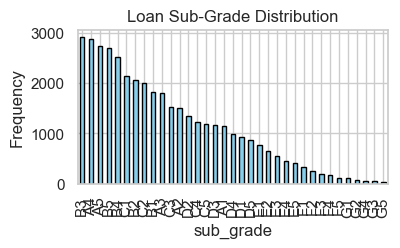

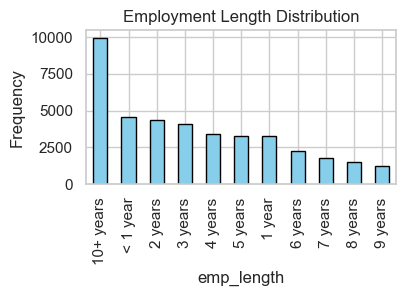

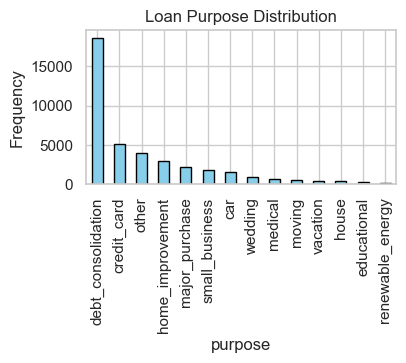

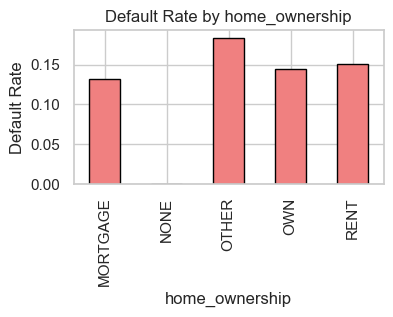

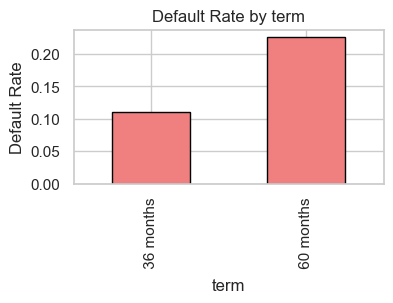

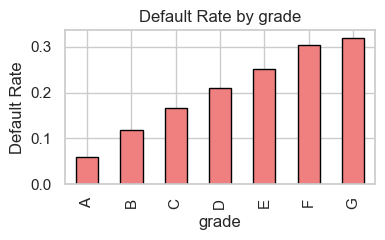

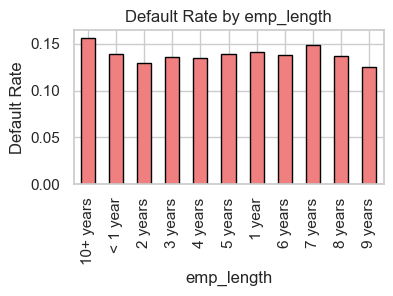

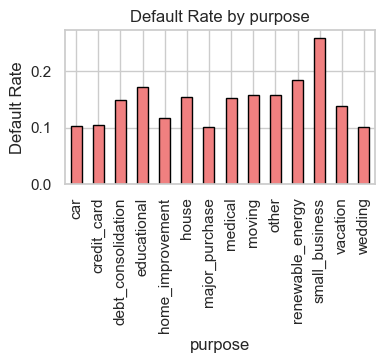

loan_amnt Skewness: 0.845883955368491
annual_inc Skewness: 0.854379827208244
dti Skewness: -0.028043330951910854
total_rec_int Skewness: 1.114580505806627
revol_bal Skewness: 1.051606836345616


In [94]:
#Data Analysis.

#univariant analysis.

# Set plot style
sns.set(style="whitegrid")

# Function to plot histograms for continuous variables

def plot_histogram(df, column, bins=30, title=None, xlabel=None, ylabel='Frequency'):
    plt.figure(figsize=(4, 2))
    df[column].hist(bins=bins, edgecolor='black')
    plt.title(title if title else f'{column} Distribution')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    plt.show()


# Function to plot bar charts for categorical variables
print("Function to plot bar charts for categorical variables\n")
def plot_bar_chart(df, column, title=None, xlabel=None, ylabel='Frequency'):
    plt.figure(figsize=(4, 2))
    df[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(title if title else f'{column} Count Distribution')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    plt.show()

# 1. Continuous Variables:
# Loan Amount Distribution
plot_histogram(df, 'loan_amnt', bins=30, title='Loan Amount Distribution', xlabel='Loan Amount')

# Annual Income Distribution
plot_histogram(df, 'annual_inc', bins=30, title='Annual Income Distribution', xlabel='Annual Income')

# Debt-to-Income Ratio Distribution
plot_histogram(df, 'dti', bins=30, title='Debt-to-Income Ratio Distribution', xlabel='Debt-to-Income Ratio')

# Total Interest Recieved Distribution
plot_histogram(df, 'total_rec_int', bins=30, title='Total Interest Received Distribution', xlabel='Total Interest')

# Revolving Balance Distribution
plot_histogram(df, 'revol_bal', bins=30, title='Revolving Balance Distribution', xlabel='Revolving Balance')

# 2. **Categorical Variables**:
# Home Ownership Distribution
plot_bar_chart(df, 'home_ownership', title='Home Ownership Distribution')

# Loan Term Distribution
plot_bar_chart(df, 'term', title='Loan Term Distribution')

# Loan Grade Distribution
plot_bar_chart(df, 'grade', title='Loan Grade Distribution')

# Sub-Grade Distribution
plot_bar_chart(df, 'sub_grade', title='Loan Sub-Grade Distribution')

# Employment Length Distribution
plot_bar_chart(df, 'emp_length', title='Employment Length Distribution')

# Loan Purpose Distribution
plot_bar_chart(df, 'purpose', title='Loan Purpose Distribution')

# 3. Default Rate by Category (Exploring correlation between categories and loan defaults)
def plot_default_rate_by_category(df, category_column, target_column='loan_status'):
    default_rate = df[df[target_column] == 'Charged Off'][category_column].value_counts() / df[category_column].value_counts()
    plt.figure(figsize=(4, 2))
    default_rate.plot(kind='bar', color='lightcoral', edgecolor='black')
    plt.title(f'Default Rate by {category_column}')
    plt.xlabel(category_column)
    plt.ylabel('Default Rate')
    plt.show()

# Default Rate by Home Ownership
plot_default_rate_by_category(df, 'home_ownership')

# Default Rate by Loan Term
plot_default_rate_by_category(df, 'term')

# Default Rate by Loan Grade
plot_default_rate_by_category(df, 'grade')

# Default Rate by Employment Length
plot_default_rate_by_category(df, 'emp_length')

# Default Rate by Loan Purpose
plot_default_rate_by_category(df, 'purpose')

# 4. **Additional Insights**: Checking skewness for continuous variables
def check_skewness(df, column):
    skewness = df[column].skew()
    print(f'{column} Skewness: {skewness}')
    return skewness

# Checking skewness for key continuous variables
continuous_columns = ['loan_amnt', 'annual_inc', 'dti', 'total_rec_int', 'revol_bal']
for col in continuous_columns:
    check_skewness(df, col)

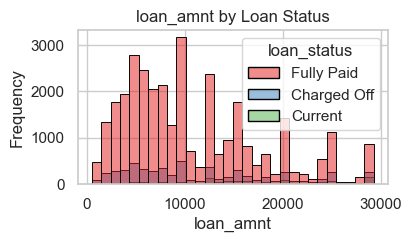

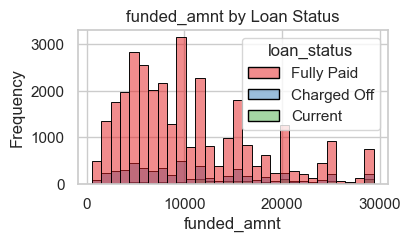

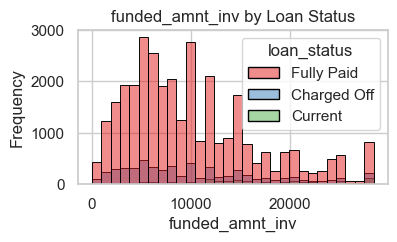

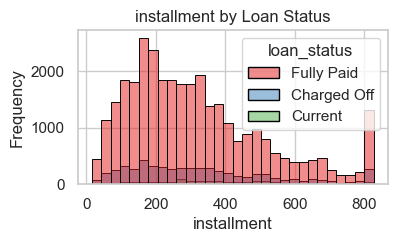

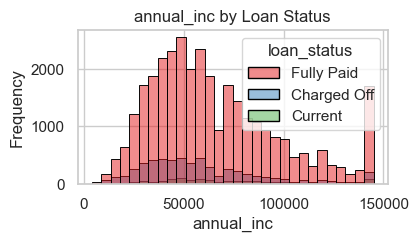

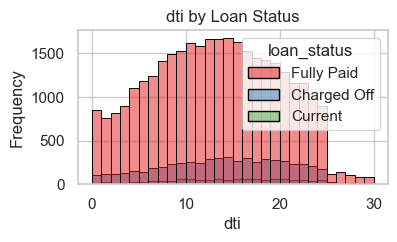

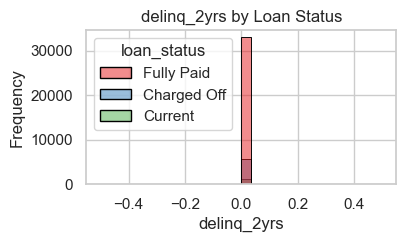

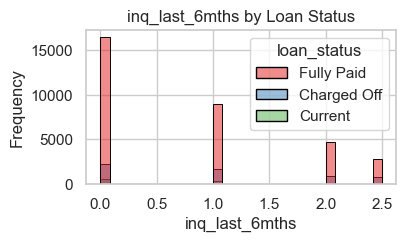

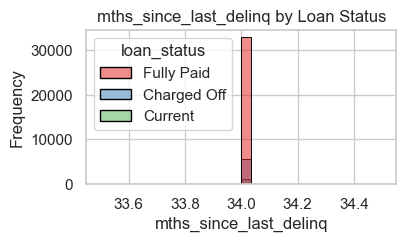

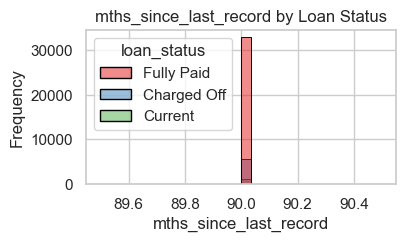

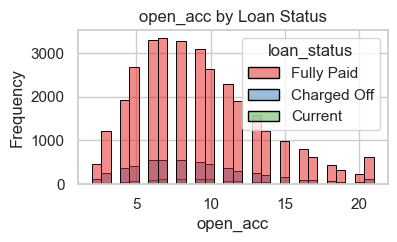

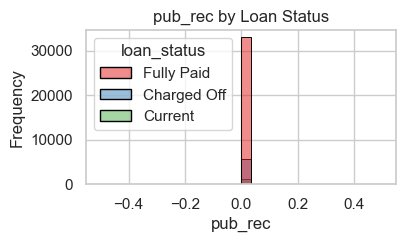

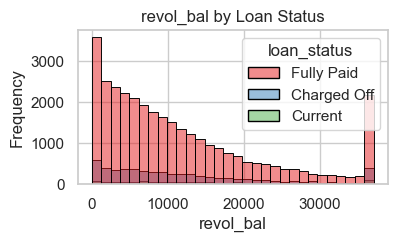

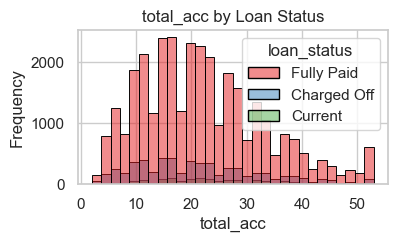

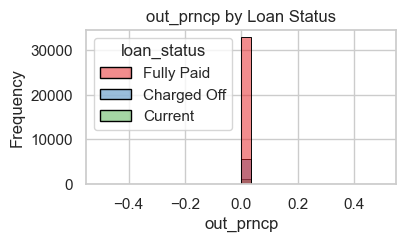

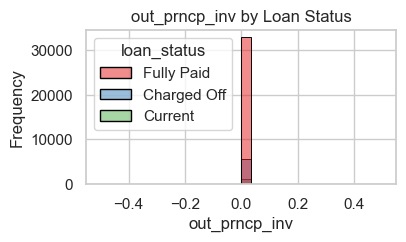

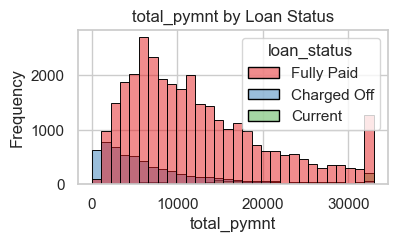

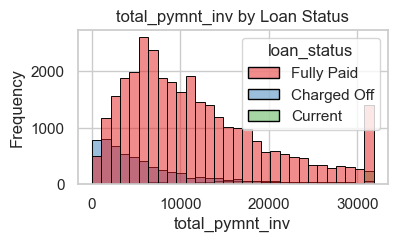

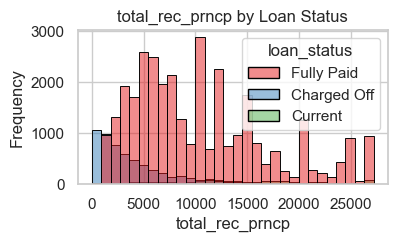

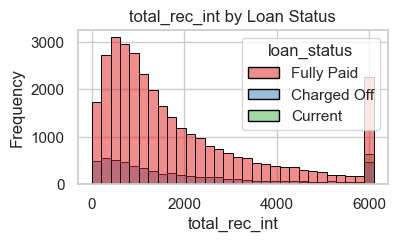

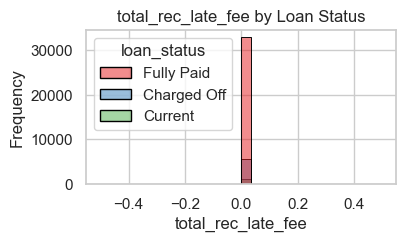

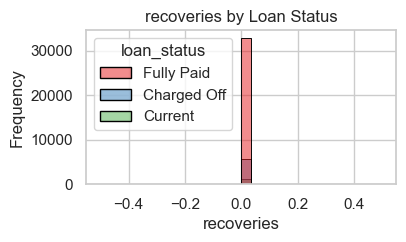

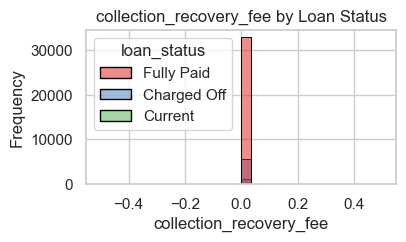

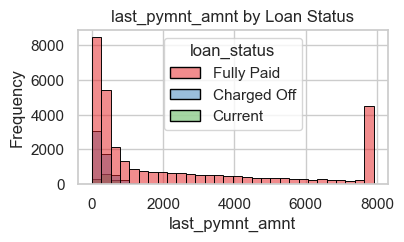

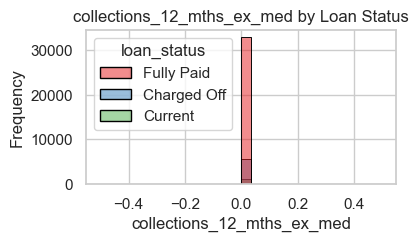

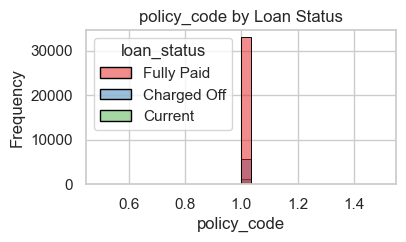

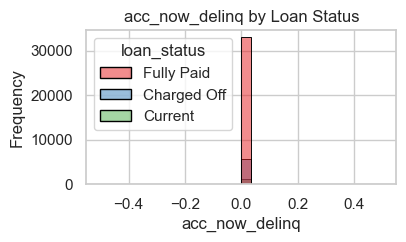

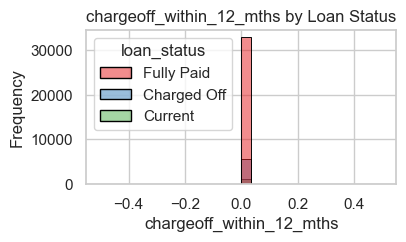

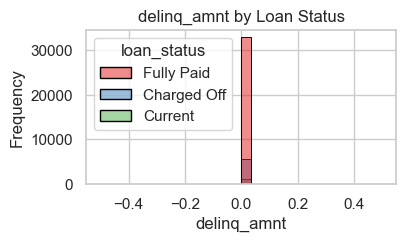

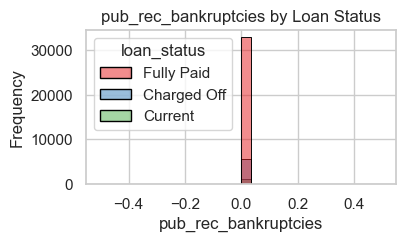

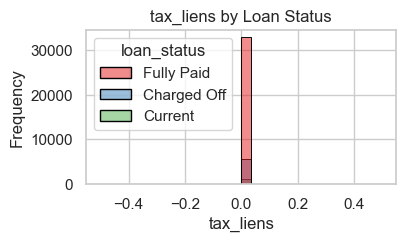

In [63]:
# 	Segmented Univariate Analysis

"""
 plot segmented histograms for continuous variables based on a categorical target variable 
 (in this case, loan_status, which indicates whether a loan is "charged off" or "fully paid")
"""

# Define the plot_histogram_segmented function for segmented analysis
def plot_histogram_segmented(df, column, target_column='loan_status', bins=30, title=None, xlabel=None, ylabel='Frequency'):
    

    # Plot histograms segmented by loan status (without KDE to avoid error)
    plt.figure(figsize=(4, 2))
    sns.histplot(data=df, x=column, hue=target_column, bins=bins, edgecolor='black', palette='Set1', kde=False)
    
    # Set titles and labels
    plt.title(title if title else f'{column} by {target_column}')
    plt.xlabel(xlabel if xlabel else column)
    plt.ylabel(ylabel)
    plt.show()

# Identify continuous columns with sufficient variance
continuous_columns = df.select_dtypes(include=[np.number]).columns

# Step 3: Segment the data based on loan status (Charged Off vs Fully Paid)
# Here 'loan_status' is the column indicating if the loan is charged off or fully paid
for column in continuous_columns:
    if column not in ['id', 'member_id']:  # Exclude non-relevant columns like id or member_id
        plot_histogram_segmented(df, column, target_column='loan_status', bins=30, title=f'{column} by Loan Status', xlabel=column)




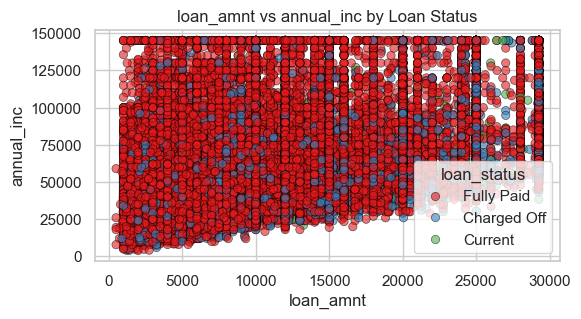

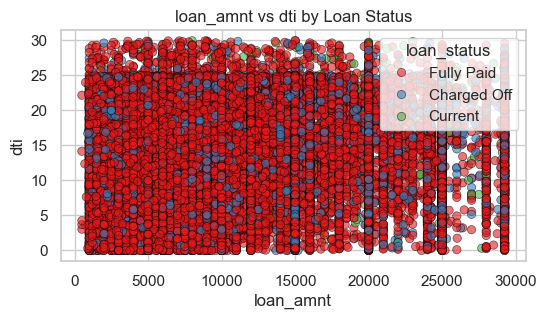

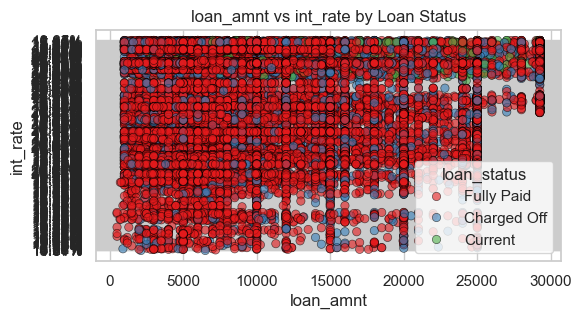

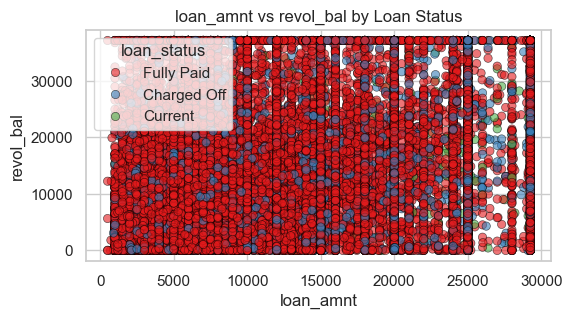

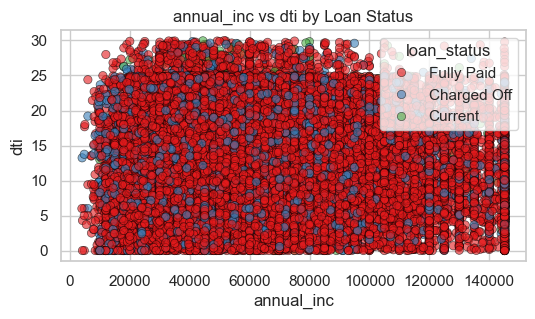

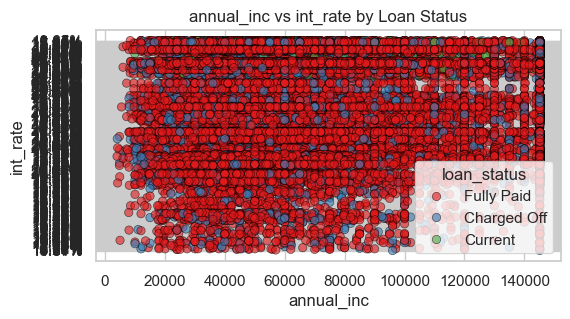

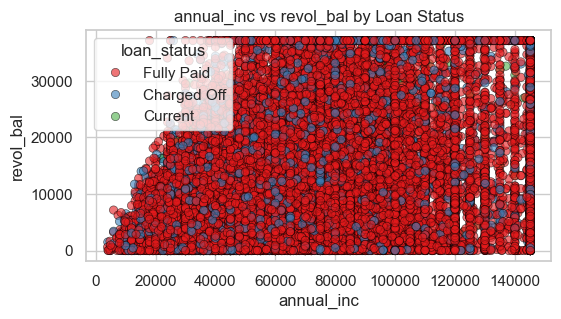

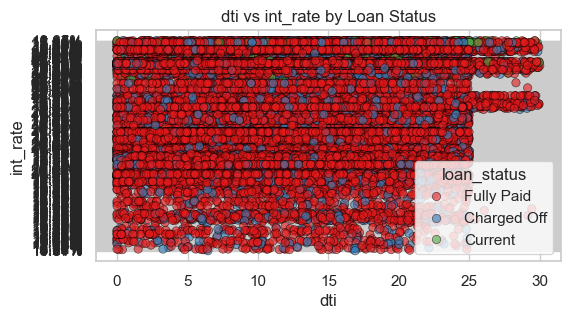

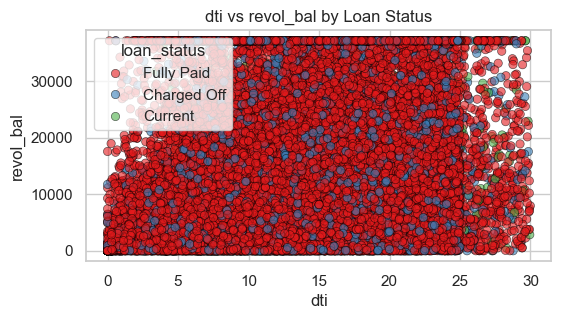

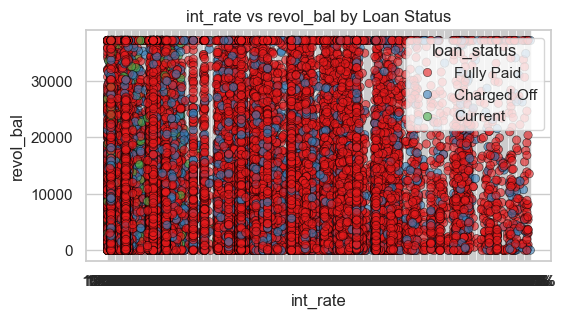

In [95]:
#Bivariant 

"""
To perform bivariate analysis on the relationship between key variables and loan default risk, 
which show interactions between the loan_status (indicating default status) and other relevant continuous variables 
(such as 'loan_amnt', 'annual_inc', 'dti', 'int_rate', 'revol_bal'). By plotting scatter plots,
we can visualize these relationships and identify patterns where certain combinations of variables correlate with higher default risk.

We'll create a function to plot scatter plots for pairs of key variables with segmentation by loan_status.
Scatter Plot Function for Bivariate Analysis
"""

# Adjust column names if necessary

import seaborn as sns
import matplotlib.pyplot as plt


def plot_scatter_bivariate(df, x_column, y_column, target_column='loan_status', title=None, xlabel=None, ylabel=None):
    """
    visualize relationships between two key variables, segmented by loan status (default vs non-default).
    """
    plt.figure(figsize=(6, 3))
    sns.scatterplot(data=df, x=x_column, y=y_column, hue=target_column, palette='Set1', edgecolor='black', alpha=0.6)
    
    plt.title(title if title else f'Relationship between {x_column} and {y_column} by {target_column}')
    plt.xlabel(xlabel if xlabel else x_column)
    plt.ylabel(ylabel if ylabel else y_column)
    plt.legend(title=target_column)
    plt.grid(True)
    plt.show()

# Bivariate Analysis: Explore key variable combinations
key_variables = ['loan_amnt', 'annual_inc', 'dti', 'int_rate', 'revol_bal']

# Loop through pairs of variables to plot scatter plots
for i in range(len(key_variables)):
    for j in range(i + 1, len(key_variables)):
        x_col = key_variables[i]
        y_col = key_variables[j]
        
        plot_scatter_bivariate(
            df, 
            x_column=x_col, 
            y_column=y_col, 
            target_column='loan_status', 
            title=f'{x_col} vs {y_col} by Loan Status', 
            xlabel=x_col, 
            ylabel=y_col
        )


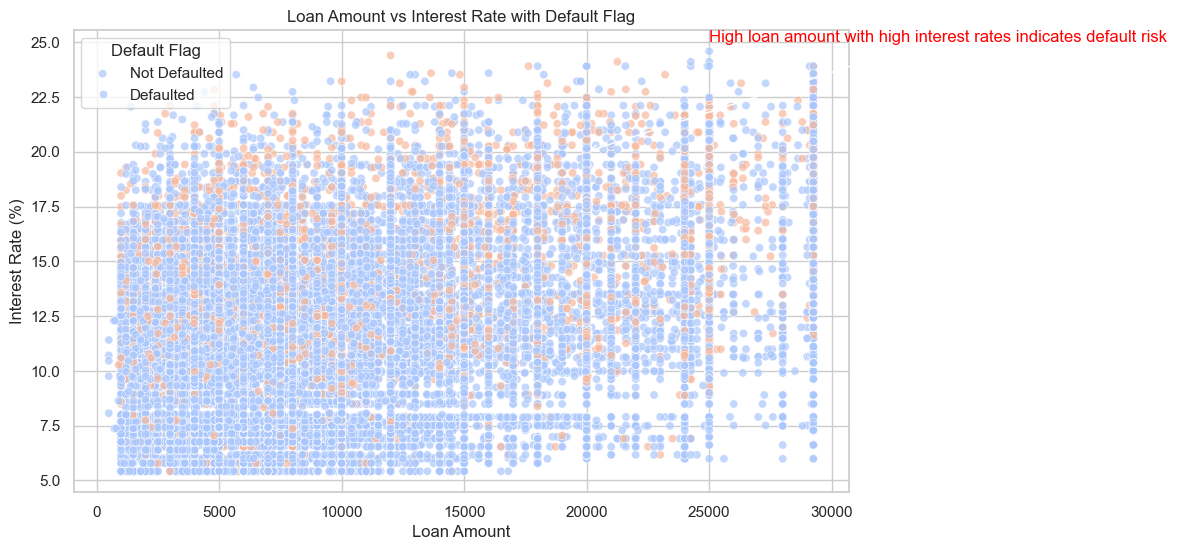

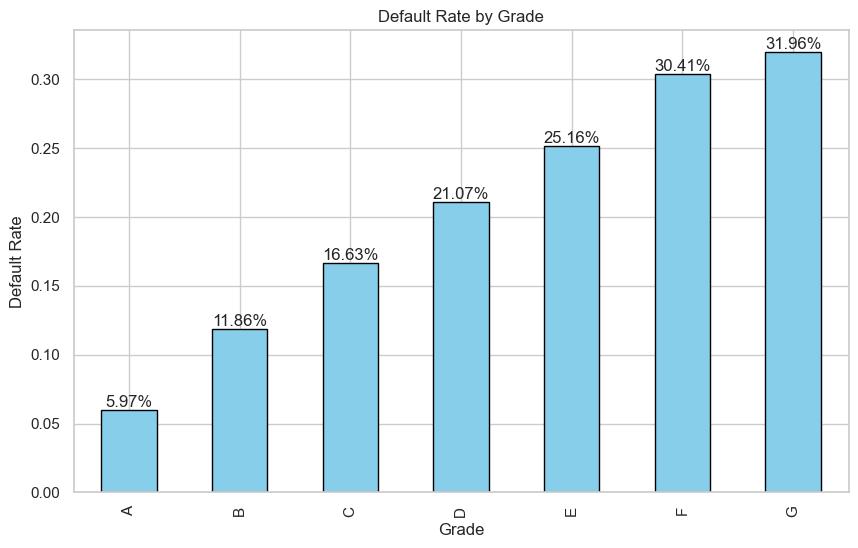

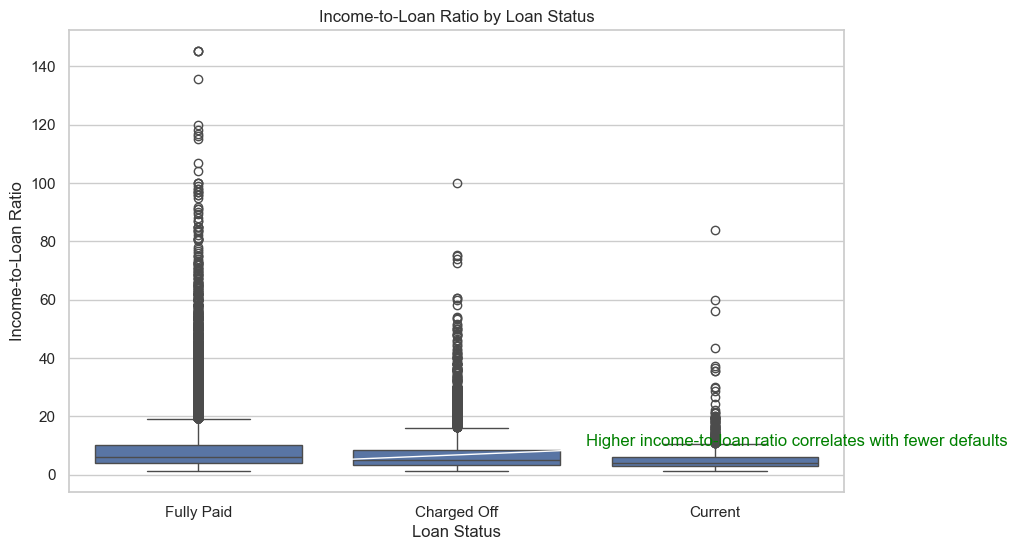

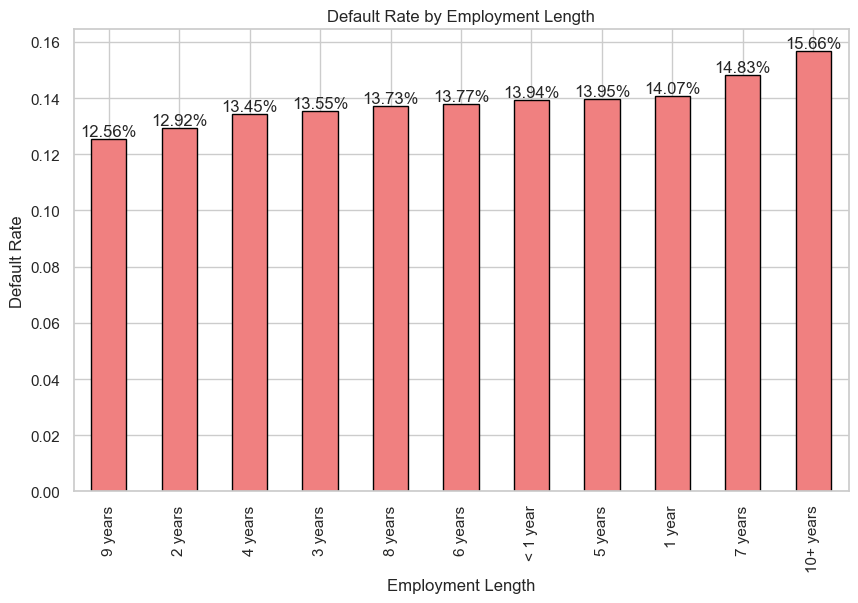

In [99]:
# Visualization and Insights


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocess the data for visualization
def preprocess_data(df):
    # Convert `int_rate` and `revol_util` to numeric after handling missing and mixed types
    df['int_rate'] = (
        df['int_rate']
        .astype(str)  
        .str.replace('%', '', regex=False)  
        .replace('nan', None)  
        .astype(float)  
    )
    
    df['revol_util'] = (
        df['revol_util']
        .astype(str)
        .str.replace('%', '', regex=False)
        .replace('nan', None)
        .astype(float)
    )
    
    # Create a derived metric for analysis: Income-to-loan ratio
    df['income_to_loan_ratio'] = df['annual_inc'] / df['loan_amnt']
    
    # Create a flag for defaults
    df['default_flag'] = df['loan_status'].apply(lambda x: 1 if x == 'Charged Off' else 0)
    return df

# Apply preprocessing func
df = preprocess_data(df)

# Visualization 1: Scatter Plot for Loan Amount vs Interest Rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='loan_amnt', y='int_rate', hue='default_flag', palette='coolwarm', alpha=0.7)
plt.title('Loan Amount vs Interest Rate with Default Flag')
plt.xlabel('Loan Amount')
plt.ylabel('Interest Rate (%)')
plt.legend(title='Default Flag', labels=['Not Defaulted', 'Defaulted'])
plt.annotate(
    'High loan amount with high interest rates indicates default risk',
    xy=(20000, 20),
    xytext=(25000, 25),
    arrowprops=dict(facecolor='red', arrowstyle='->'),
    fontsize=12,
    color='red'
)
plt.show()

# Visualization 2: Bar Plot for Default Rate by Grade
default_rate_by_grade = df.groupby('grade')['default_flag'].mean().sort_values()
plt.figure(figsize=(10, 6))
default_rate_by_grade.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Default Rate by Grade')
plt.xlabel('Grade')
plt.ylabel('Default Rate')
for index, value in enumerate(default_rate_by_grade):
    plt.text(index, value, f'{value:.2%}', ha='center', va='bottom')
plt.show()

# Visualization 3: Box Plot for Income-to-Loan Ratio by Loan Status
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='loan_status', y='income_to_loan_ratio')
plt.title('Income-to-Loan Ratio by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('Income-to-Loan Ratio')
plt.annotate(
    'Higher income-to-loan ratio correlates with fewer defaults',
    xy=(0.5, 5),
    xytext=(1.5, 10),
    arrowprops=dict(facecolor='green', arrowstyle='->'),
    fontsize=12,
    color='green'
)
plt.show()

# Visualization 4: Bar Plot for Default Rate by Employment Length
default_rate_by_emp_length = df.groupby('emp_length')['default_flag'].mean().sort_values()
plt.figure(figsize=(10, 6))
default_rate_by_emp_length.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Default Rate by Employment Length')
plt.xlabel('Employment Length')
plt.ylabel('Default Rate')
for index, value in enumerate(default_rate_by_emp_length):
    plt.text(index, value, f'{value:.2%}', ha='center', va='bottom')
plt.show()




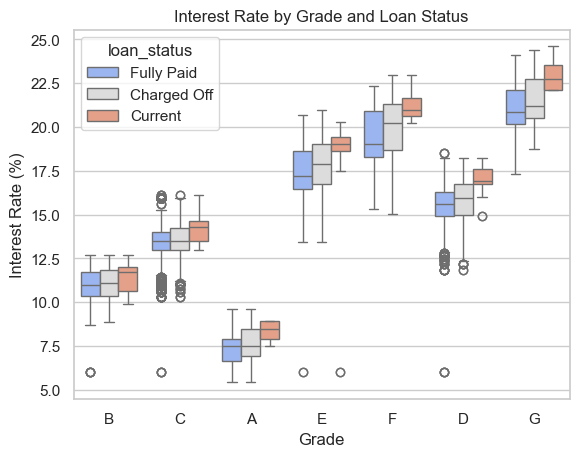

In [109]:
"""
Observation-1:
Higher interest rates are linked to default loans (Charged Off) and lower grades.

"""

# Ensure the column is treated as a string
df['int_rate'] = df['int_rate'].astype(str)

# Remove the '%' symbol and convert to float
df['int_rate'] = df['int_rate'].str.rstrip('%').astype(float)


# Visualize interest rates by grade and loan status
sns.boxplot(data=df, x='grade', y='int_rate', hue='loan_status', palette='coolwarm')
plt.title("Interest Rate by Grade and Loan Status")
plt.ylabel("Interest Rate (%)")
plt.xlabel("Grade")
plt.show()


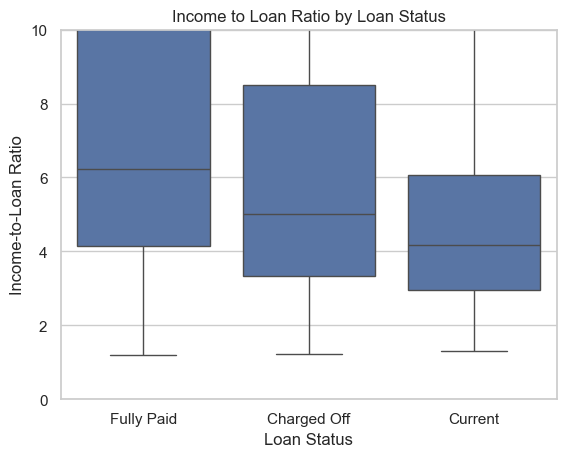

loan_status
Charged Off   5.00
Current       4.17
Fully Paid    6.24
Name: income_to_loan_ratio, dtype: float64


In [111]:
"""
Observation-2:
Lower ratios (<2x income vs. loan amount) are associated with higher defaults.

"""
df['income_to_loan_ratio'] = df['annual_inc'] / df['loan_amnt']
sns.boxplot(data=df, x='loan_status', y='income_to_loan_ratio')
plt.title("Income to Loan Ratio by Loan Status")
plt.ylabel("Income-to-Loan Ratio")
plt.xlabel("Loan Status")
plt.ylim(0, 10)  # Focus on the key range
plt.show()

# Summary statistics
ratio_summary = df.groupby('loan_status')['income_to_loan_ratio'].median()
print(ratio_summary)

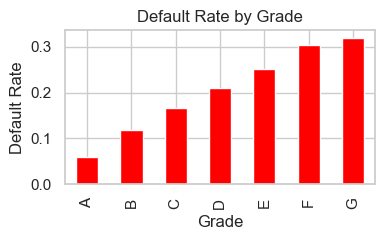

In [113]:
"""
Observation-3:
Default rates increase as grades worsen (A to G)

"""

default_rate_by_grade = df[df['loan_status'] == 'Charged Off'].groupby('grade').size() / df.groupby('grade').size()

plt.figure(figsize=(4, 2))
default_rate_by_grade.plot(kind='bar', color='red')
plt.title("Default Rate by Grade")
plt.ylabel("Default Rate")
plt.xlabel("Grade")
plt.show()

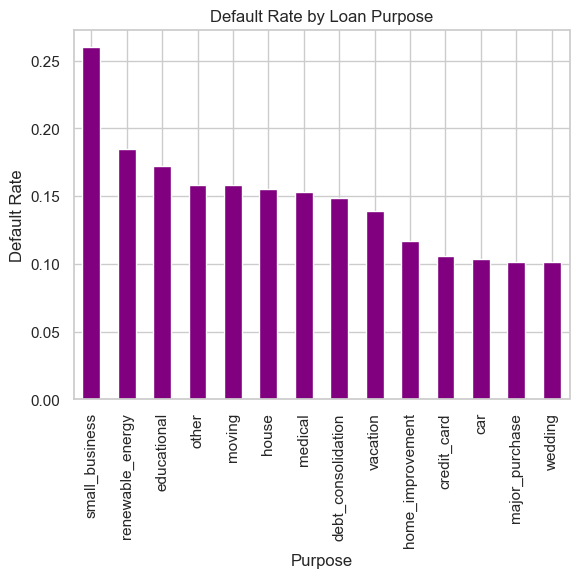

In [115]:
"""
Observation-4:
Loans for small_business and debt_consolidation show higher defaults.
"""

default_rate_by_purpose = df[df['loan_status'] == 'Charged Off'].groupby('purpose').size() / df.groupby('purpose').size()
default_rate_by_purpose.sort_values(ascending=False).plot(kind='bar', color='purple')
plt.title("Default Rate by Loan Purpose")
plt.ylabel("Default Rate")
plt.xlabel("Purpose")
plt.show()

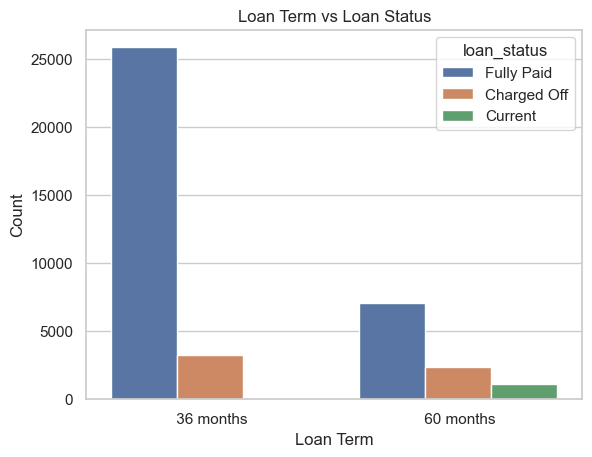

loan_status  Charged Off  Current  Fully Paid
term                                         
36 months           3227        0       25869
60 months           2400     1140        7081


In [117]:
"""
Observation-5:
Loans with shorter terms (36 months) tend to have a higher default rate compared to longer terms (60 months).
"""

sns.countplot(data=df, x='term', hue='loan_status')
plt.title("Loan Term vs Loan Status")
plt.xlabel("Loan Term")
plt.ylabel("Count")
plt.show()

# Counting the number of loans by loan term and loan status
loan_term_status_count = df.groupby(['term', 'loan_status']).size().unstack(fill_value=0)
print(loan_term_status_count)

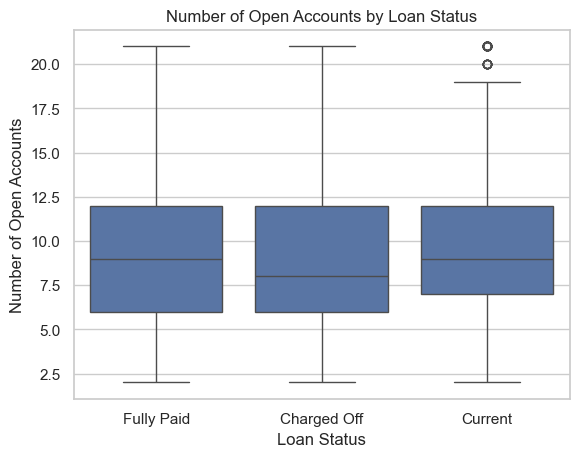

Percentage of Open Accounts by Loan Status:
loan_status
Charged Off   14.17
Current        2.87
Fully Paid    82.96
Name: open_acc, dtype: float64


In [57]:
"""
Observation-6:
OPen account does not impact on loan defaulter.
"""

sns.boxplot(data=df, x='loan_status', y='open_acc')
plt.title("Number of Open Accounts by Loan Status")
plt.xlabel("Loan Status")
plt.ylabel("Number of Open Accounts")
plt.show()

# Calculate the count of each loan status
status_counts = df['loan_status'].value_counts()

# Calculate the count of open accounts by loan status
open_acc_counts = df.groupby('loan_status')['open_acc'].count()

# Calculate the percentage of open accounts for each loan status
percentage_open_acc = (open_acc_counts / status_counts.sum()) * 100

# Print the percentage of open accounts for each loan status
print("Percentage of Open Accounts by Loan Status:")
print(percentage_open_acc)